In [2]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [ ]:
"""
code du lightgbm repris (et adapté) de :
Lien : https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's
categorical features. Other tables are using one-hot encode with mean,
sum and a few different functions to aggregate. The main ideia was to add
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import numpy as np
import pandas as pd
import time
from copy import deepcopy
import cudf
import cuml
import gc
import cupy as cp
from cuml.pipeline import Pipeline
from cuml import LogisticRegression
from cuml.pipeline import Pipeline
from cuml.preprocessing import StandardScaler
from cuml.preprocessing import SimpleImputer

# from cuml.preprocessing import RobustScaler
import matplotlib.pyplot as plt

# import seaborn as sns
import joblib
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb

# from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold


from src.p7_preprocess import WithColNames
from src.p7_feature_selection import cu_rfecv
from src.p7_util import format_time

from src.p7_metric import pd_pred_prob_to_binary
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    recall_score,
    f1_score,
)
import pickle
import warnings

from pprint import pprint
from mlflow import MlflowClient

warnings.simplefilter(action="ignore", category=FutureWarning)
## np.warnings.filterwarnings("ignore", r"All-NaN (slice|axis) encountered")
# np.seterr(all="ignore", invalid="ignore")

In [ ]:
from src.p7_feature_selection import DataSelector
from src.p7_feature_selection import cluster_features
from src.p7_simple_kernel import kfold_lightgbm_simple
from src.p7_simple_kernel import display_importances
from src.p7_full_kernel import display_full_importances
from src.p7_constantes import (
    DATA_CLEAN_DIR,
    MODEL_DIR,
    VAL_SEED,
)

from src.p7_util import timer, reduce_memory_cudf
from src.p7_preprocess import Imputer, VarianceSelector, CuRobustScaler, CuMinMaxScaler
from src.p7_preprocess import balance_nearmiss, balance_smote, get_binary_features
from src.p7_preprocess import ImputerByDtype
from src.p7_explore import plot_default_ratio, corr_sorted_map, corr_cluster_map
from src.p7_feature_selection import get_features_correlated_above, cluster_features
from src.p7_tracking import ExpCorr, ExpPermutation
from src.p7_tracking import delete_experiments_with_prefix, del_studies_from_mlflow, del_artifacts_from_mlflow
from src.p7_hyper_param import SearchLogReg
from src.p7_evaluate import plot_recall_mean


%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

In [5]:
print("cuDF version:", cudf.__version__)
print("cuML version:", cuml.__version__)

cuDF version: 24.04.01
cuML version: 24.04.00


# Données

## Lecture des données de train

In [ ]:
train = cudf.read_csv(os.path.join(DATA_CLEAN_DIR, "01_v2_vif_train.csv"))
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 523 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(157), float64(327), int64(39)
memory usage: 688.2 MB


In [7]:
train = reduce_memory_cudf(train)

Memory usage of dataframe is 780.12 MB
Memory usage after optimization is: 435.24 MB
Decreased by 44.2%


## Echantillon 30%

In [25]:
sampled_train, _ = sk_train_test_split(
    train.to_pandas(),
    test_size=0.7,
    stratify=train["TARGET"].to_pandas(),
    shuffle=True,
    random_state=VAL_SEED,
)
sampled_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69190 entries, 170245 to 38394
Columns: 523 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(157), float64(356), int64(10)
memory usage: 204.1 MB


## Sauvegarde de l'échantillon

In [9]:
filepath = os.path.join(DATA_CLEAN_DIR, "01_v2_vif_sampled_train.csv")
sampled_train.to_csv(filepath, index=False)
print(f"Echantillon (30% des données) enregistré dans {filepath}")

Echantillon (30% des données) enregistré dans data/cleaned/01_v2_vif_sampled_train.csv


# Choix des features avec RFECV

## Lecture de l'échantillon

In [140]:
cu_sampled_train = cudf.read_csv(
    os.path.join(DATA_CLEAN_DIR, "01_v2_vif_sampled_train.csv")
)
predictors = [f for f in train.columns if f not in ["SK_ID_CURR", "TARGET"]]
X = cu_sampled_train[predictors]
y = cu_sampled_train["TARGET"]
X.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Columns: 521 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(157), float64(356), int64(8)
memory usage: 205.4 MB


## RFECV sur La Régression Logistique sans rééquilibrage

In [ ]:
pipe = Pipeline(
    [
        ("imputer", WithColNames(SimpleImputer(copy=False))),
        # ("std", VarianceSelector(copy=False)),
        ("scaler", WithColNames(StandardScaler(copy=False))),
    ]
)

In [30]:
model = LogisticRegression()

t0 = time.time()
selected_features, best_score, mean_scores = cu_rfecv(
    X, y, estimator=model, pipe_prepare=pipe, min_features=40, plot_curve=True
)
duration = time.time() - t0
print(f"\nDurée (hh:mm:ss) : {format_time(duration)}")

521 features → Score = 0.8889
Suppression : 'FLAG_MOBIL' (importance=0.0000)
520 features → Score = 0.8889
Suppression : 'FLAG_DOCUMENT_12' (importance=0.0000)
519 features → Score = 0.8889
Suppression : 'BURO_CREDIT_TYPE_Interbankcredit_MEAN' (importance=0.0000)
518 features → Score = 0.8889
Suppression : 'BURO_CREDIT_TYPE_Loanforpurchaseofsharesmarginlending_MEAN' (importance=0.0000)
517 features → Score = 0.8889
Suppression : 'BURO_CREDIT_TYPE_Loanforthepurchaseofequipment_MEAN' (importance=0.0000)
516 features → Score = 0.8889
Suppression : 'POS_NAME_CONTRACT_STATUS_XNA_MEAN' (importance=0.0000)
515 features → Score = 0.8889
Suppression : 'BURO_CREDIT_TYPE_Consumercredit_MEAN' (importance=0.0002)
514 features → Score = 0.8889
Suppression : 'BURO_CREDIT_TYPE_Loanforbusinessdevelopment_MEAN' (importance=0.0002)
513 features → Score = 0.8889
Suppression : 'PREV_NAME_GOODS_CATEGORY_Gardening_MEAN' (importance=0.0001)
512 features → Score = 0.8889
Suppression : 'NAME_INCOME_TYPE_Commerc

In [31]:
print(f"{len(selected_features)} features ont été sélectionnées :")
print(selected_features)
print("Meilleur score de validation :", best_score)

420 features ont été sélectionnées :
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'LIVINGAREA_AVG', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'LANDAREA_MEDI', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DO

In [139]:
mean_scores

[0.888862373233497,
 0.8888951099738511,
 0.8888569172496468,
 0.8888596452415719,
 0.8888596452415719,
 0.8888828331729355,
 0.8888569172496468,
 0.8888746502390505,
 0.8888623734381349,
 0.8888623734381349,
 0.8888541896669976,
 0.8888364575148462,
 0.8888419134986962,
 0.8888105431263422,
 0.8888541909971446,
 0.8888132711182675,
 0.8888514638424718,
 0.8888801087065721,
 0.8888282756877695,
 0.8888160022077777,
 0.8888160020961438,
 0.8888160012588914,
 0.888854193983096,
 0.8888419179264284,
 0.8888391882880846,
 0.888839187450832,
 0.8888732873498965,
 0.8888241834952438,
 0.8888391876554701,
 0.8887955395800299,
 0.8887805356244416,
 0.8888310019402719,
 0.8888391874508322,
 0.8888037235558054,
 0.888798267571955,
 0.8888337325088724,
 0.8888105420008332,
 0.8888132715275432,
 0.8888037235558054,
 0.8887928116997384,
 0.888790084433432,
 0.8887928115881047,
 0.8888105435356181,
 0.888769622121956,
 0.8888419162800097,
 0.8887805356244416,
 0.8887573476930779,
 0.8887778086744069

## RFECV sur La Régression Logistique avec classweight

In [141]:
pipe = Pipeline(
    [
        ("imputer", WithColNames(SimpleImputer(copy=False))),
        # ("std", VarianceSelector(copy=False)),
        ("scaler", WithColNames(StandardScaler(copy=False))),
    ]
)

In [142]:
model_balanced = LogisticRegression(class_weight="balanced")

t0 = time.time()
selected_features_rfecv_balanced, best_score_balanced, mean_scores_balanced = cu_rfecv(
    X,
    y,
    estimator=model_balanced,
    pipe_prepare=pipe,
    min_features=40,
)
duration = time.time() - t0
print(f"\nDurée (hh:mm:ss) : {format_time(duration)}")

521 features → Score = 0.9117
Suppression : 'FLAG_MOBIL' (importance=0.0000)
520 features → Score = 0.9116
Suppression : 'FLAG_DOCUMENT_12' (importance=0.0000)
519 features → Score = 0.9116
Suppression : 'BURO_CREDIT_TYPE_Interbankcredit_MEAN' (importance=0.0000)
518 features → Score = 0.9115
Suppression : 'BURO_CREDIT_TYPE_Loanforpurchaseofsharesmarginlending_MEAN' (importance=0.0000)
517 features → Score = 0.9116
Suppression : 'BURO_CREDIT_TYPE_Loanforthepurchaseofequipment_MEAN' (importance=0.0000)
516 features → Score = 0.9115
Suppression : 'POS_NAME_CONTRACT_STATUS_XNA_MEAN' (importance=0.0000)
515 features → Score = 0.9115
Suppression : 'PREV_NAME_CASH_LOAN_PURPOSE_Buyingaholidayhomeland_MEAN' (importance=0.0001)
514 features → Score = 0.9116
Suppression : 'PREV_NAME_GOODS_CATEGORY_MedicalSupplies_MEAN' (importance=0.0000)
513 features → Score = 0.9117
Suppression : 'BURO_CREDIT_TYPE_Loanforbusinessdevelopment_MEAN' (importance=0.0000)
512 features → Score = 0.9118
Suppression : 

In [143]:
print(f"{len(selected_features_rfecv_balanced)} features ont été sélectionnées :")
print(selected_features_rfecv_balanced)
print("Meilleur score de validation :", best_score_balanced)

273 features ont été sélectionnées :
['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'LIVINGAREA_AVG', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'LANDAREA_MEDI', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'AMT_REQ_CREDIT_BUREAU_YEAR', '

In [144]:
mean_scores_balanced

[0.9117255464908969,
 0.9116082455636121,
 0.9115850601715942,
 0.9115441400880788,
 0.9116068798931446,
 0.9115168573037533,
 0.9115018565014956,
 0.9115645995995412,
 0.911720085837489,
 0.9118469365225078,
 0.9118332915400076,
 0.9119601437413245,
 0.9117787307525473,
 0.9118046440805314,
 0.9118769364808177,
 0.9119164945310605,
 0.9118496579753318,
 0.911893309920407,
 0.9118673888623252,
 0.9119519581285163,
 0.912108816362009,
 0.9120283390558329,
 0.9119683258657586,
 0.9120119750763784,
 0.9121620097114924,
 0.9120801700838588,
 0.911894663768017,
 0.9117964591936267,
 0.9118346459363289,
 0.9120406149547206,
 0.9120297004568465,
 0.9119956016832201,
 0.9120610696569761,
 0.9121374601750464,
 0.9120638044206556,
 0.9120433454674333,
 0.9120256140871892,
 0.9120488025302903,
 0.9120528939134364,
 0.9120228817791656,
 0.9120815323964286,
 0.9121006262283933,
 0.9119983280193408,
 0.912137453877486,
 0.9121688274496732,
 0.9121865610529911,
 0.9120447034821781,
 0.911998325907686

## Conclusion sur la méthode RFECV

In [ ]:
"""
Précis mais trop long. On va choisir une autre méthode qui nous permet de prendre moins de features.
Nous allons consentir à une légère baisse du score pour un gros gain de temps.
"""

# Evaluation de LOGREG Best features RFECV Sans Rééquilibrage

## Données

In [106]:
print(f"{len(selected_features)} features ont été sélectionnées :")
print(selected_features)

420 features ont été sélectionnées :
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'LIVINGAREA_AVG', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'LANDAREA_MEDI', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DO

In [120]:
cu_sampled_train = cudf.read_csv(
    os.path.join(DATA_CLEAN_DIR, "01_v2_vif_sampled_train.csv")
)

X = cu_sampled_train[selected_features]
y = cu_sampled_train["TARGET"]
X.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Columns: 420 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(122), float64(290), int64(8)
memory usage: 167.7 MB


## Exécution

In [121]:
pipe = Pipeline(
    [
        ("imputer", WithColNames(SimpleImputer(copy=False))),
        # ("std", VarianceSelector(copy=False)),
        ("scaler", WithColNames(StandardScaler(copy=False))),
    ]
)

In [122]:
t0 = time.time()
dic_train_scores, dic_val_scores = cu_cross_evaluate(
    X_train_and_val=X,
    pipe_preprocess=pipe,
    cuml_model=LogisticRegression(),
    y_train_and_val=y,
    train_scores=True,
    n_folds=5,
)
duration = time.time() - t0
print(f"Durée de l'évaluation : {format_time(duration)}")

Durée de l'évaluation : 0:00:15


In [125]:
mean_val_scores = {k: np.mean(v) for (k, v) in dic_val_scores.items()}
mean_val_scores

{'auc': 0.7619054675102234,
 'accuracy': 0.9185431361198425,
 'recall': 0.03399535236057482,
 'f1_score': 0.06301364706945183,
 'business_gain': 0.8888910279202211,
 'fit_time': 2.3578235626220705,
 'tn': 12672.8,
 'tp': 38.0,
 'fn': 1079.8,
 'fp': 47.4}

In [126]:
mean_train_scores = {k: np.mean(v) for (k, v) in dic_train_scores.items()}
mean_train_scores

{'auc': 0.7822975397109986,
 'accuracy': 0.9194861888885498,
 'recall': 0.037439507796017193,
 'f1_score': 0.06987014175071493,
 'business_gain': 0.8894103482099375,
 'fit_time': 2.3578235626220705,
 'tn': 50728.0,
 'tp': 167.4,
 'fn': 4303.8,
 'fp': 152.8}

## Plot Scores d'entraînement et de validation

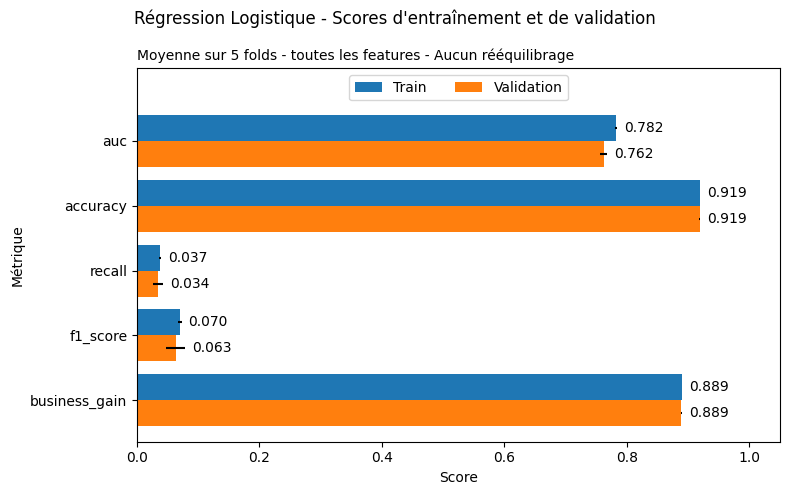

In [127]:
# On plotte les scores d'évaluation
fig = plot_evaluation_scores(
    train_scores=dic_train_scores,
    val_scores=dic_val_scores,
    title="Régression Logistique - Scores d'entraînement et de validation",
    subtitle="Moyenne sur 5 folds - toutes les features - Aucun rééquilibrage",
    verbose=True,
)

## Plot Matrice confusion

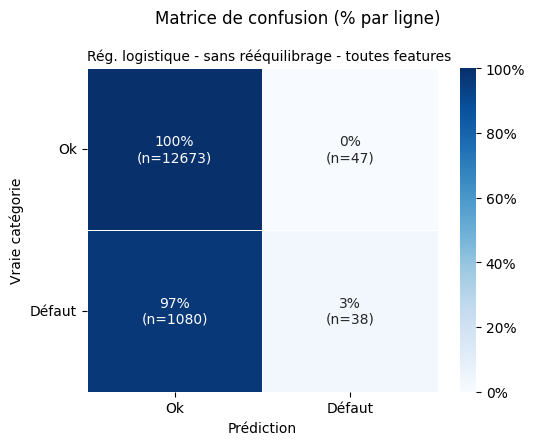

In [128]:
plot_recall_mean(
    tn=mean_val_scores["tn"],
    fp=mean_val_scores["fp"],
    fn=mean_val_scores["fn"],
    tp=mean_val_scores["tp"],
    subtitle="Rég. logistique - sans rééquilibrage - toutes features",
)

# Evaluation de LOGREG Best features RFECV avec CLASS_WEIGHT

In [145]:
print(f"{len(selected_features_rfecv_balanced)} features ont été sélectionnées :")
print(selected_features_rfecv_balanced)

273 features ont été sélectionnées :
['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'LIVINGAREA_AVG', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'LANDAREA_MEDI', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'AMT_REQ_CREDIT_BUREAU_YEAR', '

In [146]:
cu_sampled_train = cudf.read_csv(
    os.path.join(DATA_CLEAN_DIR, "01_v2_vif_sampled_train.csv")
)

X = cu_sampled_train[selected_features_rfecv_balanced]
y = cu_sampled_train["TARGET"]
X.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Columns: 273 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(50), float64(216), int64(7)
memory usage: 122.8 MB


## Exécution

In [147]:
pipe = Pipeline(
    [
        ("imputer", WithColNames(SimpleImputer(copy=False))),
        # ("std", VarianceSelector(copy=False)),
        ("scaler", WithColNames(StandardScaler(copy=False))),
    ]
)

In [158]:
t0 = time.time()
model = LogisticRegression(class_weight="balanced")

train_scores_balanced, val_scores_balanced = cu_cross_evaluate(
    X_train_and_val=X,
    pipe_preprocess=pipe,
    cuml_model=model,
    y_train_and_val=y,
    train_scores=True,
    n_folds=5,
)
duration = time.time() - t0
print(f"Durée de l'évaluation : {format_time(duration)}")

Durée de l'évaluation : 0:00:13


In [159]:
mean_val_scores_balanced = {k: np.mean(v) for (k, v) in val_scores_balanced.items()}
mean_val_scores_balanced

{'auc': 0.7672119617462159,
 'accuracy': 0.7047260046005249,
 'recall': 0.6936835665427618,
 'f1_score': 0.27515265757172996,
 'business_gain': 0.9139106204077713,
 'fit_time': 1.7655763626098633,
 'tn': 8976.6,
 'tp': 775.4,
 'fn': 342.4,
 'fp': 3743.6}

In [160]:
mean_train_scores_balanced = {k: np.mean(v) for (k, v) in train_scores_balanced.items()}
mean_train_scores_balanced

{'auc': 0.7823875546455383,
 'accuracy': 0.7094305515289306,
 'recall': 0.7148862736562279,
 'f1_score': 0.28442659705055195,
 'business_gain': 0.9168997946144384,
 'fit_time': 1.7655763626098633,
 'tn': 36072.0,
 'tp': 3196.4,
 'fn': 1274.8,
 'fp': 14808.8}

## Plot Scores d'entraînement et de validation

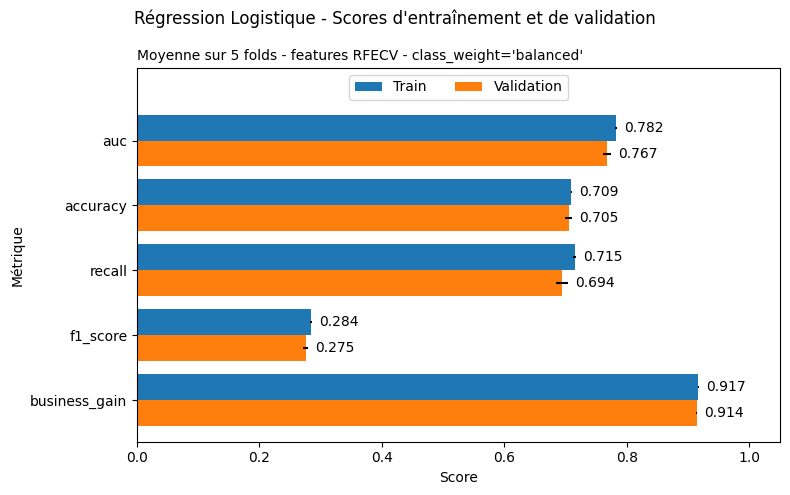

In [162]:
# On plotte les scores d'évaluation
fig = plot_evaluation_scores(
    train_scores=train_scores_balanced,
    val_scores=val_scores_balanced,
    title="Régression Logistique - Scores d'entraînement et de validation",
    subtitle="Moyenne sur 5 folds - features RFECV - class_weight='balanced'",
    verbose=True,
)

## Plot Matrice confusion

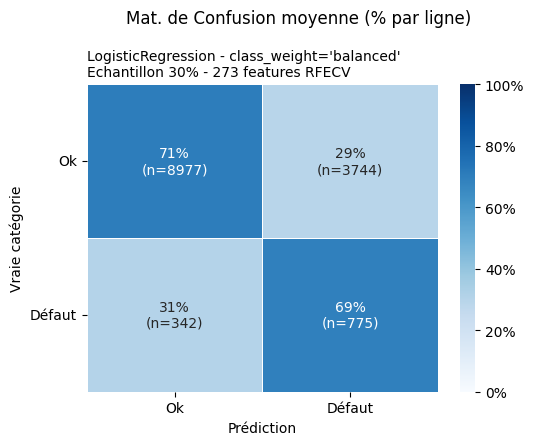

In [166]:
title = f"Mat. de Confusion moyenne (% par ligne)"
subtitle = f"{model.__class__.__name__} - class_weight='balanced'\nEchantillon 30% - {len(selected_features_rfecv_balanced)} features RFECV"
plot_recall_mean(
    tn=mean_val_scores_balanced["tn"],
    fp=mean_val_scores_balanced["fp"],
    fn=mean_val_scores_balanced["fn"],
    tp=mean_val_scores_balanced["tp"],
    title=title,
    subtitle=subtitle,
)

# Choix des features avec un modèle à base d'arbres

## Importances moyennens sur toutes les données

In [33]:
from src.p7_importance import (
    importance_from_model,
    plot_line_importance,
    plot_bar_importances,
)

In [34]:
X = train.drop(columns=["SK_ID_CURR", "TARGET"]).to_pandas()
y = train["TARGET"].to_pandas()

print("Info X :")
print(X.info())
print("\nInfo y :")
print("Classe", y.__class__.__name__)
print("Type", y.dtype)
print("Shape", y.shape)

Info X :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 521 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(157), float64(356), int64(8)
memory usage: 675.0 MB
None

Info y :
Classe Series
Type int64
Shape (230634,)


In [35]:
clf = lgb.LGBMClassifier(
    n_threads=14,
    class_weight="balanced",
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,  # Pour ne pas voir les logs
)

In [36]:
params = clf.get_params()
params

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'n_threads': 14,
 'verbosity': -1}

In [38]:
t0 = time.time()
importances = importance_from_model(clf, X, y, n_splits=5)
duration = time.time() - t0
print(f"Durée du calcul des importances : {format_time(duration)}")
importances.head()

Durée du calcul des importances : 0:00:26


,importance_mean,importance_std,rank_importance,missing_pct
feature,,,,
EXT_SOURCE_1,125.2,4.147288,1,56.289185
EXT_SOURCE_2,112.2,2.774887,2,0.208556
EXT_SOURCE_3,101.6,6.228965,3,19.816679
CREDIT_TO_ANNUITY_RATIO,100.0,9.823441,4,0.003469
DAYS_EMPLOYED,68.4,6.913754,5,18.019459


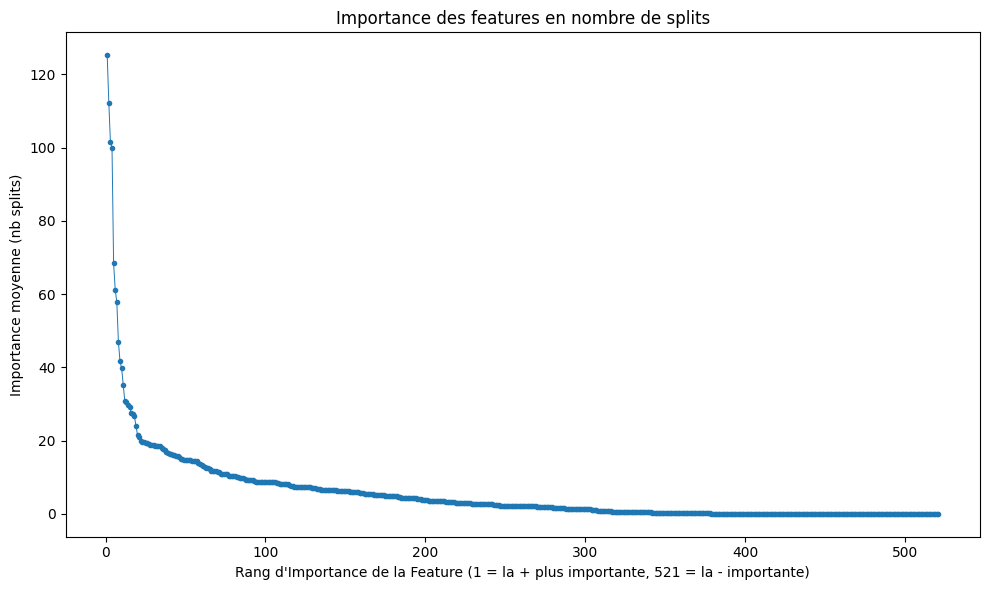

In [39]:
fig_line_importance = plot_line_importance(importances)

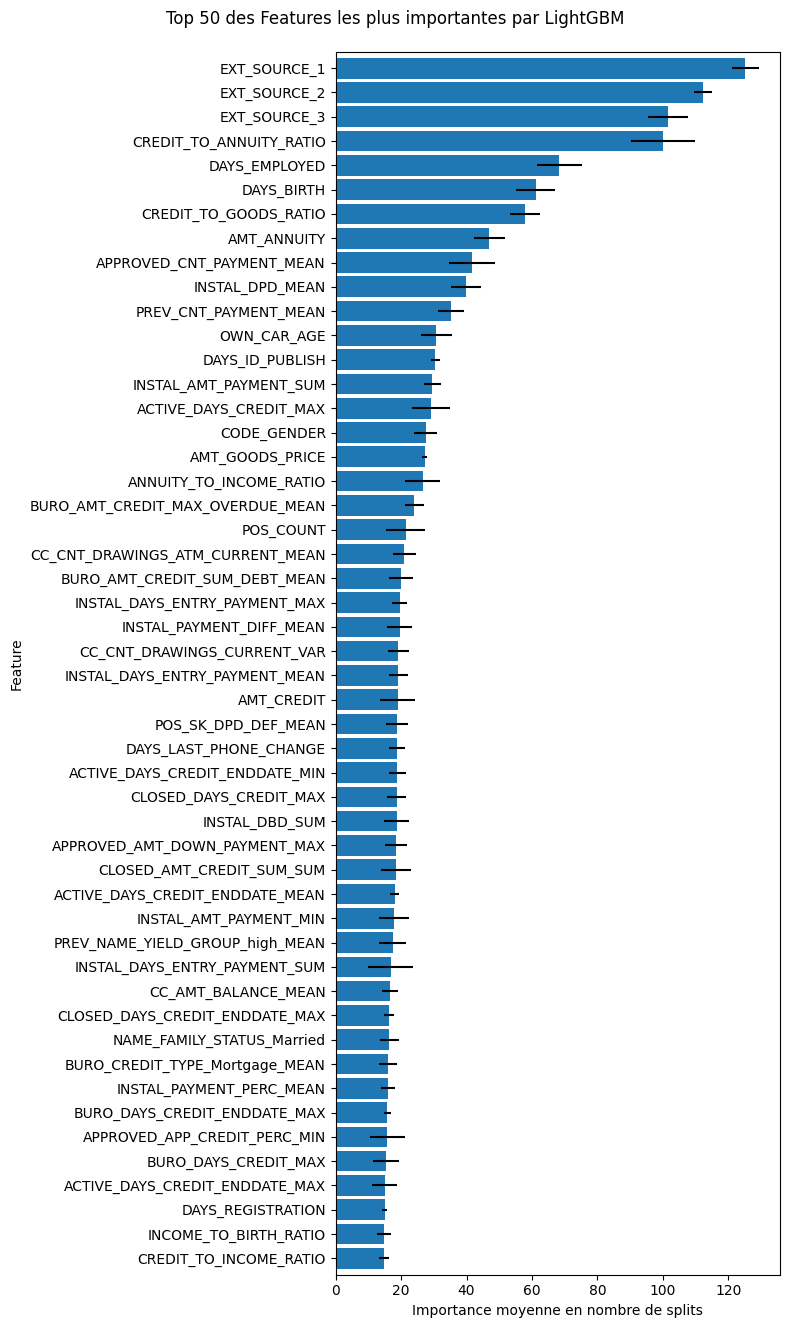

In [41]:
fig_bar_importance = plot_bar_importances(importances, top=50)

## Lecture de l'échantillon 30%

In [51]:
cu_sampled_train = cudf.read_csv(
    os.path.join(DATA_CLEAN_DIR, "01_v2_vif_sampled_train.csv")
)
predictors = [f for f in train.columns if f not in ["SK_ID_CURR", "TARGET"]]
X = cu_sampled_train[predictors]
y = cu_sampled_train["TARGET"]
X.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Columns: 521 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(157), float64(356), int64(8)
memory usage: 205.4 MB


## Metrique Business_gain

In [93]:
# Calcule le score métier. Le score maximum est 1
def compute_business_gain(tn, fp, fn, tp, gain_tp=5, gain_tn=1, loss_fp=1, loss_fn=10):
    gain = gain_tp * tp + gain_tn * tn - loss_fp * fp - loss_fn * fn

    # Nombre de défauts réels
    n_default = tp + fn
    # Nombre de remboursements OK réels
    n_ok = tn + fp

    # Maximum de gain métier en valeur, si on a tout prédit correctement
    max_gain = gain_tp * n_default + gain_tn * n_ok
    # Minimum de gain métier en valeur, si toutes les prédictions sont fausses
    min_gain = -loss_fp * n_default - loss_fn * n_ok
    # On ramène en pourcentage
    normalized_gain = (gain - min_gain) / (max_gain - min_gain)
    return normalized_gain

## Métrique f1_score pour cuda

In [ ]:
def cu_f1_score(tp, fn, fp):
    # Précision et Rappel
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # F1-score
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) != 0
        else 0
    )
    return f1

In [59]:
from src.p7_metric import cu_pred_prob_to_binary, cupd_recall_score
from copy import deepcopy

## Fonction pour validation croisée sur cuml

In [119]:
# [TODO] intégrer un pipe avec corrélation et permutation ?
def cu_cross_evaluate(
    X_train_and_val,
    pipe_preprocess,
    cuml_model,
    pipe_postprocess=None,
    balance="none",
    k_neighbors=5,
    y_train_and_val=None,
    train_scores=False,
    threshold_prob=0.5,
    n_folds=4,
    random_state=42,
    verbose=False,
):
    """
    predictors = [
        f
        for f in X_train_and_val.columns
        if f not in ["TARGET", "SK_ID_CURR", "Unnamed: 0"]
    ]
    # A faire avant le pipe
    # binary_features = get_binary_features(train_and_val)

    predictors_without_nan = [
        f for f in predictors if X_train_and_val[f].isna().sum() == 0
    ]

    X_tmp = X_train_and_val[["SK_ID_CURR", predictors_without_nan[0]]].to_numpy(
        copy=True
    )
    if y_train_and_val is not None:
        y_tmp = y_train_and_val.to_pandas()
    else:
        y_tmp = X_train_and_val["TARGET"].to_pandas()
    """

    predictors = [
        f for f in X_train_and_val.columns if f not in ["SK_ID_CURR", "TARGET"]
    ]

    folds = cuml.model_selection.StratifiedKFold(
        n_splits=n_folds,
        shuffle=True,
        random_state=random_state,
    )

    dic_val_scores = {
        "auc": [],
        "accuracy": [],
        "recall": [],
        "f1_score": [],
        "business_gain": [],
        "fit_time": [],
        "tn": [],
        "tp": [],
        "fn": [],
        "fp": [],
    }

    if train_scores:
        dic_train_scores = deepcopy(dic_val_scores)

    for train_idx_array, valid_idx_array in folds.split(
        X_train_and_val, y_train_and_val
    ):
        """train_idx = train_idx_array.tolist()
        valid_idx = valid_idx_array.tolist()"""
        train_idx = train_idx_array
        valid_idx = valid_idx_array
        t0_fit_time = time.time()
        X_train = X_train_and_val[predictors].iloc[train_idx]
        X_val = X_train_and_val[predictors].iloc[valid_idx]

        if y_train_and_val is None:
            y_train = X_train_and_val.loc[train_idx, "TARGET"]
            y_val = X_train_and_val.loc[valid_idx, "TARGET"]
        else:
            y_train = y_train_and_val.iloc[train_idx]
            y_val = y_train_and_val.iloc[valid_idx]

        # print(f"\tPrétraitement")
        pipe = deepcopy(pipe_preprocess)
        X_train_processed = pipe.fit_transform(X_train)
        X_val_processed = pipe.transform(X_val)

        # Eventuel rééquilibrage avec SMOTE ou NearMiss
        if balance == "none":
            X_train_balanced = X_train_processed.copy()
            y_train_balanced = y_train.copy()
        elif balance == "smote":
            X_train_balanced, y_train_balanced = balance_smote(
                X_train_processed,
                y_train,
                k_neighbors=k_neighbors,
                random_state=random_state,
                verbose=verbose,
            )
        elif balance == "nearmiss":
            X_train_balanced, y_train_balanced, features_null_var = balance_nearmiss(
                X_train_processed, y_train, k_neighbors=k_neighbors, verbose=verbose
            )
        else:
            print(
                f"{balance} est une valeur incorrecte pour balance. Les valeurs possibles sont 'none', 'smote' ou 'nearmiss'"
            )

        # Afin de repartir d'un modèle non fitté, on crée une nouvelle copie du modèle passé en paramètre
        clf = deepcopy(cuml_model)
        clf.fit(X_train_balanced, y_train_balanced)

        fit_time = time.time() - t0_fit_time

        ############### Prédictions et mesures sur le Jeu de TRAIN
        if train_scores:

            # Probabilité d'appartenir à la classe default pour le jeu de train
            y_score_train = clf.predict_proba(X_train_balanced)[1]
            # Prédiction de la classe en fonction du seuil de probabilité
            y_pred_train = cu_pred_prob_to_binary(
                y_score_train, threshold=threshold_prob
            )

            # Order C applatit la matrice en ligne comme ravel() de numpy, mais
            # Attention, ne renvoie pas des scalaires mais des cupy ndarrays
            mat = cuml.metrics.confusion_matrix(y_train_balanced, y_pred_train)
            tn_array, fp_array, fn_array, tp_array = mat.ravel(order="C")
            # On extrait les scalaires des cupy ndarrays()
            tn = tn_array.item()
            fp = fp_array.item()
            fn = fn_array.item()
            tp = tp_array.item()
            dic_train_scores["tn"].append(tn)
            dic_train_scores["fn"].append(fn)
            dic_train_scores["tp"].append(tp)
            dic_train_scores["fp"].append(fp)

            # Mesures sur le jeu de train
            dic_train_scores["auc"].append(
                cuml.metrics.roc_auc_score(y_train_balanced, y_score_train)
            )
            dic_train_scores["accuracy"].append(
                cuml.metrics.accuracy_score(y_train_balanced, y_pred_train)
            )
            dic_train_scores["recall"].append(cupd_recall_score(tp=tp, fn=fn))
            dic_train_scores["f1_score"].append(cu_f1_score(tp=tp, fp=fp, fn=fn))
            dic_train_scores["business_gain"].append(
                compute_business_gain(tp=tp, fn=fn, tn=tn, fp=fp)
            )

            dic_train_scores["fit_time"].append(fit_time)

        ############### Prédictions et mesures sur le Jeu de VALIDATION

        # Probabilité d'appartenir à la classe default pour le jeu de validation
        y_score_val = clf.predict_proba(X_val_processed)[1]
        # Prédiction de la classe en fonction du seuil de probabilité
        y_pred_val = cu_pred_prob_to_binary(y_score_val, threshold=threshold_prob)

        # Order C applatit la matrice en ligne comme ravel() de numpy, mais
        # Attention, ne renvoie pas des scalaires mais des cupy ndarrays
        mat = cuml.metrics.confusion_matrix(y_val, y_pred_val)
        tn_array, fp_array, fn_array, tp_array = mat.ravel(order="C")
        # On extrait les scalaires des cupy ndarrays()
        tn = tn_array.item()
        fp = fp_array.item()
        fn = fn_array.item()
        tp = tp_array.item()
        dic_val_scores["tn"].append(tn)
        dic_val_scores["fn"].append(fn)
        dic_val_scores["tp"].append(tp)
        dic_val_scores["fp"].append(fp)

        # Mesures sur le jeu de validation
        dic_val_scores["auc"].append(cuml.metrics.roc_auc_score(y_val, y_score_val))
        dic_val_scores["accuracy"].append(
            cuml.metrics.accuracy_score(y_val, y_pred_val)
        )
        dic_val_scores["recall"].append(cupd_recall_score(tp=tp, fn=fn))
        dic_val_scores["f1_score"].append(cu_f1_score(tp=tp, fp=fp, fn=fn))
        dic_val_scores["business_gain"].append(
            compute_business_gain(tp=tp, fn=fn, tn=tn, fp=fp)
        )

        dic_val_scores["fit_time"].append(fit_time)

    del pipe
    del clf
    gc.collect()
    cp._default_memory_pool.free_all_blocks()
    if train_scores:
        return dic_train_scores, dic_val_scores
    else:
        return dic_val_scores

## Evaluation de LOGREG avec les features d'arbres

### Avec 60 features

In [130]:
features60 = list(importances.index)[:60]
features60

['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CREDIT_TO_ANNUITY_RATIO',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'CREDIT_TO_GOODS_RATIO',
 'AMT_ANNUITY',
 'APPROVED_CNT_PAYMENT_MEAN',
 'INSTAL_DPD_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'OWN_CAR_AGE',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'ACTIVE_DAYS_CREDIT_MAX',
 'CODE_GENDER',
 'AMT_GOODS_PRICE',
 'ANNUITY_TO_INCOME_RATIO',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'POS_COUNT',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'CC_CNT_DRAWINGS_CURRENT_VAR',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'AMT_CREDIT',
 'POS_SK_DPD_DEF_MEAN',
 'DAYS_LAST_PHONE_CHANGE',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'INSTAL_DBD_SUM',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'PREV_NAME_YIELD_GROUP_high_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'CC_AMT_BALANCE_MEA

In [ ]:
cu_sampled_train = cudf.read_csv(
    os.path.join(DATA_CLEAN_DIR, "01_v2_vif_sampled_train.csv")
)
# predictors = [f for f in train.columns if f not in ["SK_ID_CURR", "TARGET"]]
X = cu_sampled_train[features60]
y = cu_sampled_train["TARGET"]
X.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Data columns (total 60 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   EXT_SOURCE_1                         30377 non-null  float64
 1   EXT_SOURCE_2                         69053 non-null  float64
 2   EXT_SOURCE_3                         55679 non-null  float64
 3   CREDIT_TO_ANNUITY_RATIO              69187 non-null  float64
 4   DAYS_EMPLOYED                        56817 non-null  float64
 5   DAYS_BIRTH                           69190 non-null  int64
 6   CREDIT_TO_GOODS_RATIO                69126 non-null  float64
 7   AMT_ANNUITY                          69187 non-null  float64
 8   APPROVED_CNT_PAYMENT_MEAN            65290 non-null  float64
 9   INSTAL_DPD_MEAN                      65640 non-null  float64
 10  PREV_CNT_PAYMENT_MEAN                65406 non-null  float64
 11  OWN_CAR_AGE                     

In [132]:
pipe = Pipeline(
    [
        ("imputer", WithColNames(SimpleImputer(copy=False))),
        # ("std", VarianceSelector(copy=False)),
        ("scaler", WithColNames(StandardScaler(copy=False))),
    ]
)

In [133]:
t0 = time.time()
dic_train_scores, dic_val_scores = cu_cross_evaluate(
    X_train_and_val=X,
    pipe_preprocess=pipe,
    cuml_model=LogisticRegression(),
    y_train_and_val=y,
    train_scores=True,
    n_folds=5,
)
duration = time.time() - t0
print(f"Durée de l'évaluation : {format_time(duration)}")

Durée de l'évaluation : 0:00:05


In [134]:
mean_val_scores = {k: np.mean(v) for (k, v) in dic_val_scores.items()}
mean_val_scores

{'auc': 0.7520942926406861,
 'accuracy': 0.9190634489059448,
 'recall': 0.015924170767917516,
 'f1_score': 0.030785023338146512,
 'business_gain': 0.8871983072548829,
 'fit_time': 0.40915570259094236,
 'tn': 12700.2,
 'tp': 17.8,
 'fn': 1100.0,
 'fp': 20.0}

In [135]:
mean_train_scores = {k: np.mean(v) for (k, v) in dic_train_scores.items()}
mean_train_scores

{'auc': 0.7552665591239929,
 'accuracy': 0.9190959453582763,
 'recall': 0.015700475215151187,
 'f1_score': 0.03039182296532474,
 'business_gain': 0.8871822768299309,
 'fit_time': 0.40915570259094236,
 'tn': 50803.6,
 'tp': 70.2,
 'fn': 4401.0,
 'fp': 77.2}

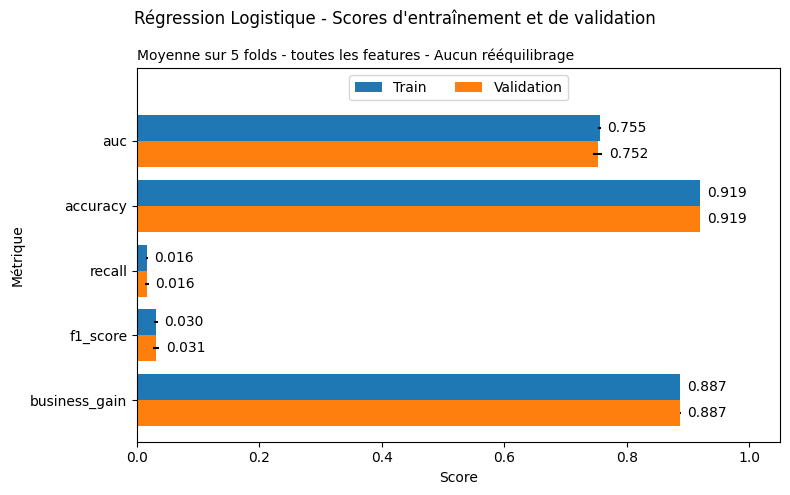

In [136]:
# On plotte les scores d'évaluation
fig = plot_evaluation_scores(
    train_scores=dic_train_scores,
    val_scores=dic_val_scores,
    title="Régression Logistique - Scores d'entraînement et de validation",
    subtitle="Moyenne sur 5 folds - toutes les features - Aucun rééquilibrage",
    verbose=True,
)

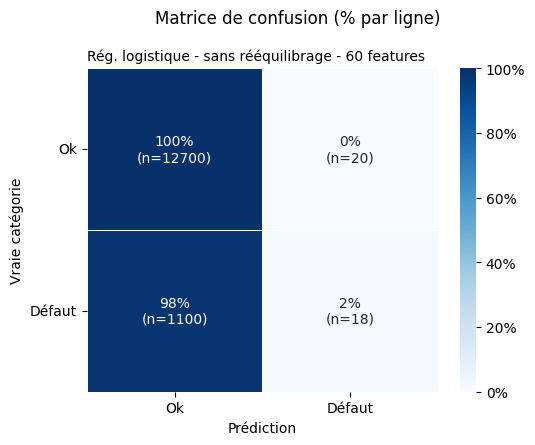

In [138]:
plot_recall_mean(
    tn=mean_val_scores["tn"],
    fp=mean_val_scores["fp"],
    fn=mean_val_scores["fn"],
    tp=mean_val_scores["tp"],
    subtitle="Rég. logistique - sans rééquilibrage - 60 features",
)

### Avec 60 features de l'arbre

In [29]:
features160 = list(importances.index)[:160]

In [31]:
X = sampled_train[features160]
y = sampled_train["TARGET"]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69190 entries, 170245 to 38394
Columns: 160 entries, EXT_SOURCE_1 to CLOSED_DAYS_CREDIT_MEAN
dtypes: bool(5), float32(128), float64(22), int32(3), int64(2)
memory usage: 48.1 MB


## Fonction score en validation croisée pour sklearn

In [ ]:
def sk_cross_evaluate(
    model,
    X,
    y,
    pipe_preprocess=None,
    balance="none",
    k_neighbors=5,
    train_scores=True,
    threshold_prob=0.5,
    n_folds=5,
    random_state=VAL_SEED,
    verbose=False,
):

    folds = StratifiedKFold(
        n_splits=n_folds,
        shuffle=True,
        random_state=random_state,
    )

    dic_val_scores = {
        "auc": [],
        "accuracy": [],
        "recall": [],
        "f1_score": [],
        "business_gain": [],
        "fit_time": [],
        "tn": [],
        "tp": [],
        "fn": [],
        "fp": [],
    }

    if train_scores:
        dic_train_scores = deepcopy(dic_val_scores)

    for train_idx, valid_idx in folds.split(X, y):
        t0_fit_time = time.time()
        X_train = X.iloc[train_idx]
        X_val = X.iloc[valid_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[valid_idx]

        pipe = None
        if pipe_preprocess:
            pipe = deepcopy(pipe_preprocess)
            X_train_processed = pipe.fit_transform(X_train)
            X_val_processed = pipe.transform(X_val)
        else:
            X_train_processed = X_train
            X_val_processed = X_val

        # Eventuel rééquilibrage avec SMOTE ou NearMiss
        if balance == "none":
            X_train_balanced = X_train_processed.copy()
            y_train_balanced = y_train.copy()
        elif balance == "smote":
            X_train_balanced, y_train_balanced = balance_smote(
                X_train_processed,
                y_train,
                k_neighbors=k_neighbors,
                random_state=random_state,
                verbose=verbose,
            )
        elif balance == "nearmiss":
            X_train_balanced, y_train_balanced, features_null_var = balance_nearmiss(
                X_train_processed, y_train, k_neighbors=k_neighbors, verbose=verbose
            )
        else:
            print(
                f"{balance} est une valeur incorrecte pour balance. Les valeurs possibles sont 'none', 'smote' ou 'nearmiss'"
            )

        # Afin de repartir d'un modèle non fitté, on crée une nouvelle copie du modèle passé en paramètre
        clf = deepcopy(model)
        clf.fit(X_train_balanced, y_train_balanced)

        fit_time = time.time() - t0_fit_time

        ############### Prédictions et mesures sur le Jeu de TRAIN
        if train_scores:

            # Probabilité d'appartenir à la classe default pour le jeu de train
            # print("shape X_train_balanced", X_train_balanced.shape)
            # print(clf.predict_proba(X_train_balanced))
            y_prob_train = clf.predict_proba(X_train_balanced)[:, 1]
            # print("len(y_prob_train)", len(y_prob_train))
            # print("shape", y_prob_train.shape)
            # Prédiction de la classe en fonction du seuil de probabilité
            y_pred_train = pd_pred_prob_to_binary(
                y_prob_train, threshold=threshold_prob
            )
            # y_pred_train = pd.Series([int(proba > 0.5) for proba in y_prob_train])
            # print("len(y_pred_train)", len(y_pred_train))
            # print("shape", y_pred_train.shape)
            tn, fp, fn, tp = confusion_matrix(y_train_balanced, y_pred_train).ravel()

            dic_train_scores["tn"].append(tn)
            dic_train_scores["fn"].append(fn)
            dic_train_scores["tp"].append(tp)
            dic_train_scores["fp"].append(fp)

            # Mesures sur le jeu de train
            dic_train_scores["auc"].append(
                roc_auc_score(y_train_balanced, y_prob_train)
            )
            dic_train_scores["accuracy"].append(
                accuracy_score(y_train_balanced, y_pred_train)
            )
            dic_train_scores["recall"].append(
                recall_score(y_train_balanced, y_pred_train)
            )
            dic_train_scores["f1_score"].append(
                f1_score(y_train_balanced, y_pred_train)
            )
            dic_train_scores["business_gain"].append(
                compute_business_gain(tp=tp, fn=fn, tn=tn, fp=fp)
            )
            dic_train_scores["fit_time"].append(fit_time)

        ############### Prédictions et mesures sur le Jeu de VALIDATION

        # Probabilité d'appartenir à la classe default pour le jeu de validation
        y_prob_val = clf.predict_proba(X_val_processed)[:, 1]
        # Prédiction de la classe en fonction du seuil de probabilité
        y_pred_val = pd_pred_prob_to_binary(y_prob_val, threshold=threshold_prob)

        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()

        dic_val_scores["tn"].append(tn)
        dic_val_scores["fn"].append(fn)
        dic_val_scores["tp"].append(tp)
        dic_val_scores["fp"].append(fp)

        # Mesures sur le jeu de validation
        dic_val_scores["auc"].append(roc_auc_score(y_val, y_prob_val))
        dic_val_scores["accuracy"].append(accuracy_score(y_val, y_pred_val))
        dic_val_scores["recall"].append(recall_score(y_val, y_pred_val))
        dic_val_scores["f1_score"].append(f1_score(y_val, y_pred_val))
        dic_val_scores["business_gain"].append(
            compute_business_gain(tp=tp, fn=fn, tn=tn, fp=fp)
        )

        dic_val_scores["fit_time"].append(fit_time)
    if pipe:
        del pipe
    del clf
    gc.collect()
    # print(dic_val_scores)
    if train_scores:
        return dic_train_scores, dic_val_scores
    else:
        return dic_val_scores

## Sans rééquilibrage

In [60]:
clf = lgb.LGBMClassifier(
    n_threads=14,
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,  # Pour ne pas voir les logs
)
params = clf.get_params()
params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'n_threads': 14,
 'verbosity': -1}

In [ ]:
dic_train_scores, dic_val_scores = sk_cross_evaluate(model=clf, X=X, y=y)

CPU times: user 52.7 s, sys: 35.6 ms, total: 52.7 s
Wall time: 4.38 s


In [71]:
mean_val_scores = {k: np.mean(v) for (k, v) in dic_val_scores.items()}
mean_val_scores

{'auc': 0.7674057854865569,
 'accuracy': 0.9190634484752133,
 'recall': 0.043120068289229874,
 'business_gain': 0.8898935414811359,
 'fit_time': 0.7272350311279296,
 'tn': 12669.8,
 'tp': 48.2,
 'fn': 1069.6,
 'fp': 50.4}

In [72]:
mean_train_scores = {k: np.mean(v) for (k, v) in dic_train_scores.items()}
mean_train_scores

{'auc': 0.931824277787066,
 'accuracy': 0.9305065760948115,
 'recall': 0.1469406899322167,
 'business_gain': 0.9023423048986665,
 'fit_time': 0.7272350311279296,
 'tn': 50848.4,
 'tp': 657.0,
 'fn': 3814.2,
 'fp': 32.4}

## Graphique

In [70]:
def set_vertical_margins(ax, top=0.15, bottom=0.05):
    """Ajoute des marges haute et basse inégales à un graphique

    Args:
        ax (Axes): Sous-plot matplotlib
        top (float, optional): Marge haute. Defaults to 0.15.
        bottom (float, optional): Marge basse. Defaults to 0.05.
    """
    ax.set_ymargin(0)
    ax.autoscale_view()
    lim = ax.get_ylim()
    delta = np.diff(lim)
    top = lim[0] - delta * top
    bottom = lim[1] + delta * bottom
    ax.set_ylim(top, bottom)

In [72]:
def plot_evaluation_scores(
    train_scores,
    val_scores,
    title="Scores de validation croisée\n",
    subtitle="",
    figsize=(8, 5),
    verbose=True,
):

    not_to_plot = ["fp", "fn", "tp", "tn", "fit_time"]
    metric_names = [k for k in train_scores.keys() if k not in not_to_plot]

    # Les dictionnaires en paramètres contiennent des listes de scores pour pour tous les folds,
    # On construit le dictionnaire contenant les scores moyens pour le train et la validation
    mean_scores = {
        "Train": [np.mean(v) for k, v in train_scores.items() if k not in not_to_plot],
        "Validation": [
            np.mean(v) for k, v in val_scores.items() if k not in not_to_plot
        ],
    }
    # On calcule les écart_types pour les afficher sous forme de barre d'erreur
    errors = {
        "Train": [np.std(v) for k, v in train_scores.items() if k not in not_to_plot],
        "Validation": [
            np.std(v) for k, v in val_scores.items() if k not in not_to_plot
        ],
    }

    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(title)

    if subtitle:
        ax.set_title(
            subtitle,
            ha="left",
            x=0,
            fontsize=ax.xaxis.label.get_fontsize(),
        )

    # Graphique en barres horizontales
    y_pos = np.arange(len(metric_names))  # Cordonnée verticale des groupes de barres
    bar_height = 0.4  # Epaisseur des barres
    multiplier = 0

    for jdd, mean_score in mean_scores.items():
        offset = bar_height * multiplier
        rects = ax.barh(
            y=y_pos + offset,
            width=mean_score,
            height=-bar_height,
            label=jdd,
            align="edge",
            xerr=errors[jdd],
        )
        ax.bar_label(rects, fmt="%0.3f", padding=5)
        multiplier += 1

    ax.set_xlabel("Score")
    ax.set_ylabel("Métrique")
    ax.set_xlim(0, 1)
    ax.set_yticks(y_pos, metric_names)
    ax.set_xlim(0, 1.05)
    # On place une marge en haut et on affiche la légende au dessus des barres
    set_vertical_margins(ax=ax, top=0.15, bottom=0.05)
    ax.invert_yaxis()
    plt.legend(loc="upper center", ncol=2)
    plt.tight_layout()
    if not verbose:
        plt.close()
    return fig

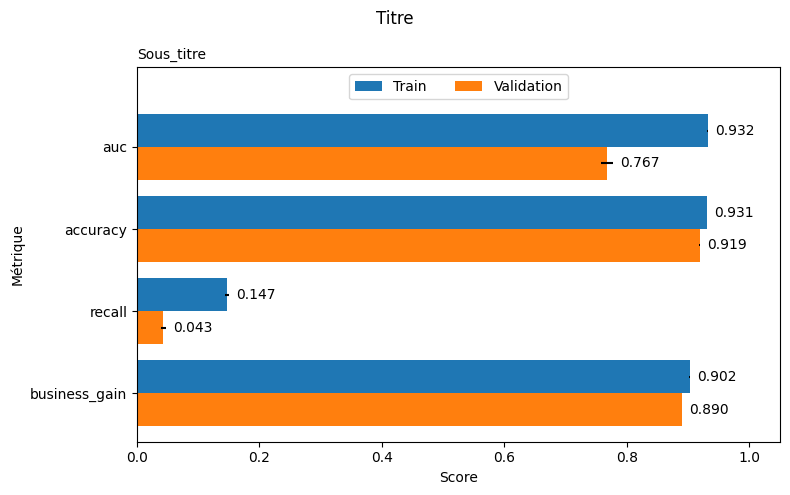

In [77]:
# On plotte les scores d'évaluation
fig = plot_evaluation_scores(
    train_scores=dic_train_scores,
    val_scores=dic_val_scores,
    title="Titre",
    subtitle="Sous_titre",
    verbose=True,
)

# En prenant 100 features

In [96]:
features100 = list(importances.index)[:100]
X = sampled_train[features100]
y = sampled_train["TARGET"]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69190 entries, 170245 to 38394
Data columns (total 100 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   EXT_SOURCE_1                             30377 non-null  float32
 1   EXT_SOURCE_2                             69053 non-null  float32
 2   CREDIT_TO_ANNUITY_RATIO                  69187 non-null  float32
 3   EXT_SOURCE_3                             55679 non-null  float32
 4   DAYS_EMPLOYED                            56817 non-null  float32
 5   DAYS_BIRTH                               69190 non-null  int64  
 6   AMT_ANNUITY                              69187 non-null  float32
 7   CREDIT_TO_GOODS_RATIO                    69126 non-null  float32
 8   INSTAL_DPD_MEAN                          65640 non-null  float32
 9   APPROVED_CNT_PAYMENT_MEAN                65290 non-null  float32
 10  PREV_CNT_PAYMENT_MEAN                    6540

In [97]:
clf = lgb.LGBMClassifier(
    n_threads=14,
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,  # Pour ne pas voir les logs
)
params = clf.get_params()
params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'n_threads': 14,
 'verbosity': -1}

In [98]:

%time dic_train_scores, dic_val_scores = lgbm_cross_validate(model=clf, X=X, y=y)

CPU times: user 40.2 s, sys: 13.1 ms, total: 40.2 s
Wall time: 3.24 s


In [99]:
mean_val_scores = {k: np.mean(v) for (k, v) in dic_val_scores.items()}
mean_val_scores

{'auc': 0.766444454321799,
 'accuracy': 0.9190200896083249,
 'recall': 0.044373745801990064,
 'business_gain': 0.8900094755101792,
 'fit_time': 0.5187256813049317,
 'tn': 12667.8,
 'tp': 49.6,
 'fn': 1068.2,
 'fp': 52.4}

In [100]:
mean_train_scores = {k: np.mean(v) for (k, v) in dic_train_scores.items()}
mean_train_scores

{'auc': 0.9273889934670658,
 'accuracy': 0.929935684347449,
 'recall': 0.14094662522021262,
 'business_gain': 0.9016405344294233,
 'fit_time': 0.5187256813049317,
 'tn': 50843.6,
 'tp': 630.2,
 'fn': 3841.0,
 'fp': 37.2}

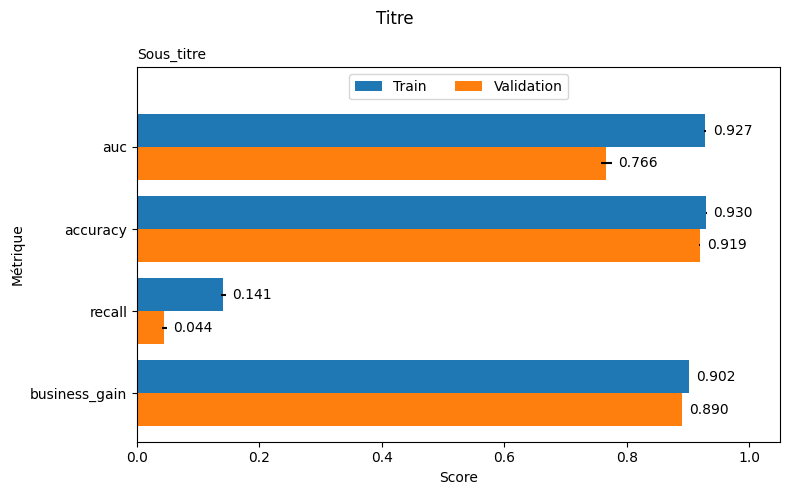

In [101]:
# On plotte les scores d'évaluation
fig = plot_evaluation_scores(
    train_scores=dic_train_scores,
    val_scores=dic_val_scores,
    title="Titre",
    subtitle="Sous_titre",
    verbose=True,
)

# En prenant n features

Nombre de features : 80
Nombre de features : 60
Nombre de features : 50
Nombre de features : 40
Nombre de features : 30


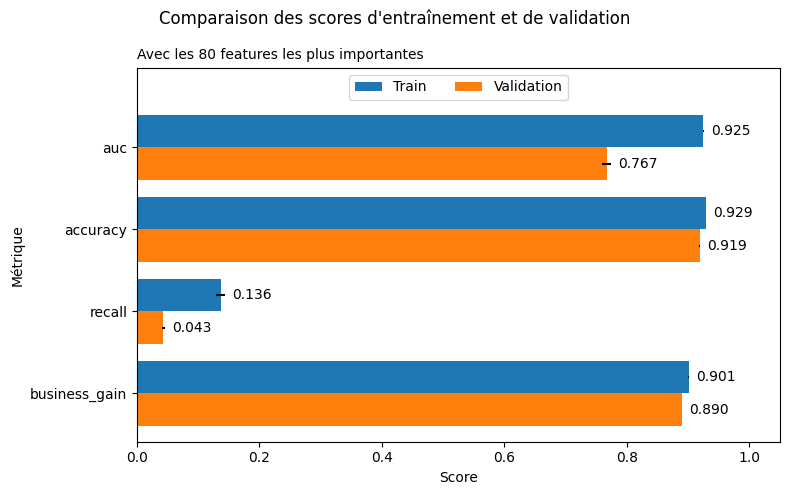

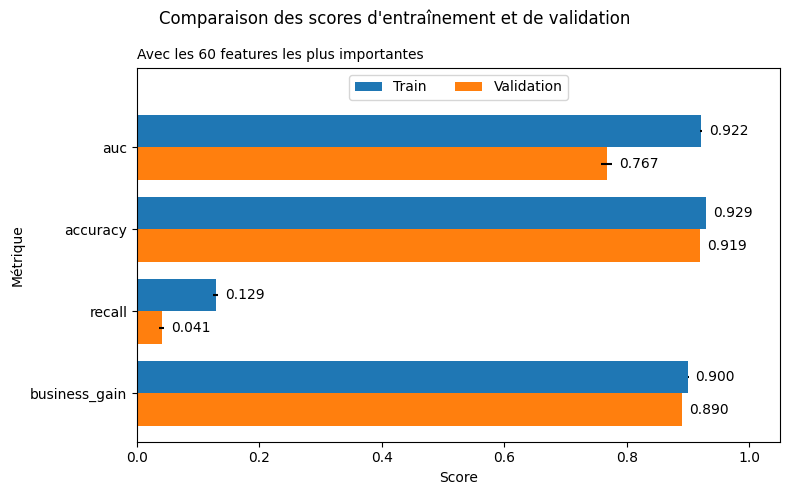

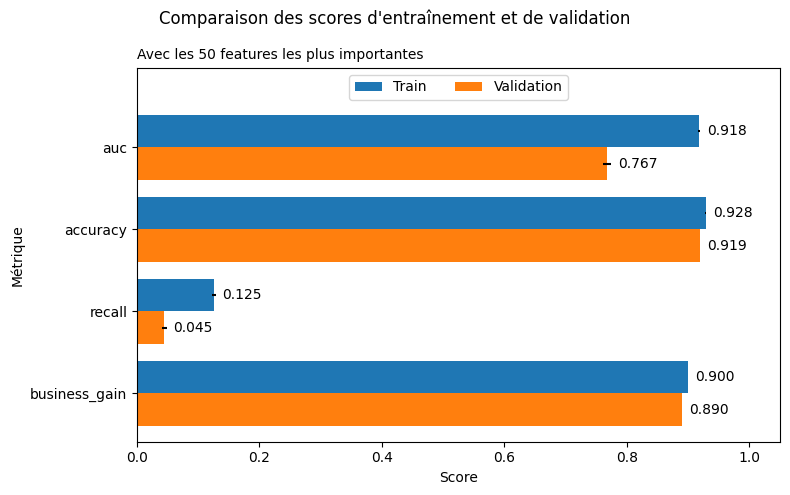

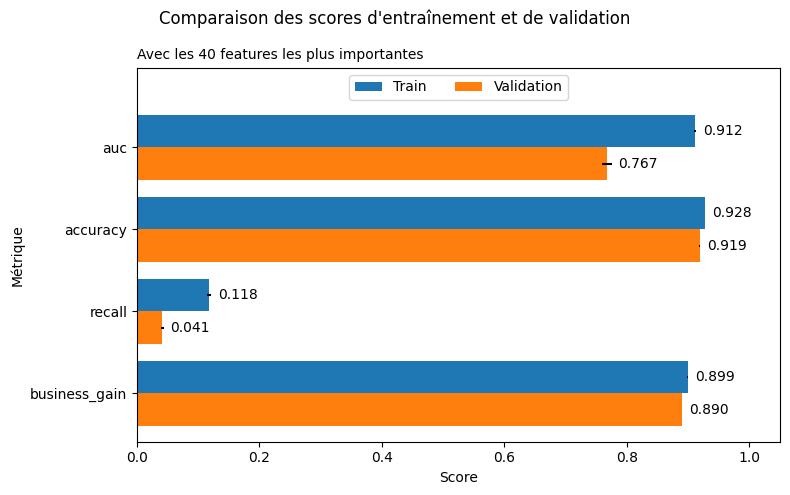

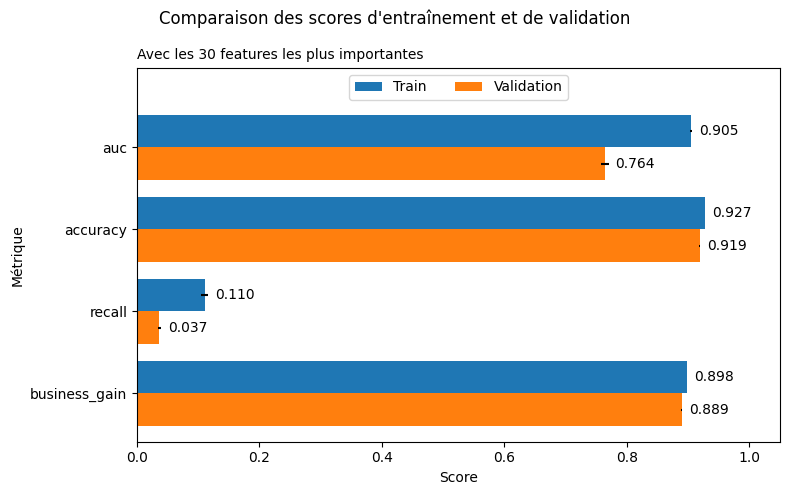

In [116]:
for n_features in [80, 60, 50, 40, 30]:
    print(f"Nombre de features : {n_features}")
    features = list(importances.index)[:n_features]
    X = sampled_train[features]
    y = sampled_train["TARGET"]

    clf = lgb.LGBMClassifier(
        n_threads=14,
        objective="binary",
        random_state=VAL_SEED,
        verbosity=-1,  # Pour ne pas voir les logs
    )
    dic_train_scores, dic_val_scores = lgbm_cross_validate(model=clf, X=X, y=y)

    fig = plot_evaluation_scores(
        train_scores=dic_train_scores,
        val_scores=dic_val_scores,
        title="Comparaison des scores d'entraînement et de validation",
        subtitle=f"Avec les {n_features} features les plus importantes",
        verbose=True,
    )

# On choisit 50 features

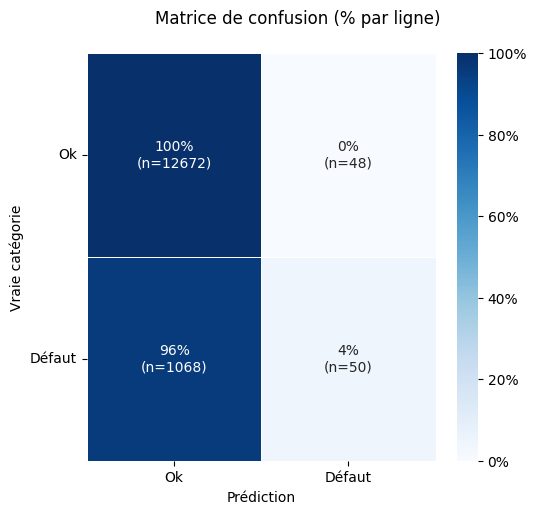

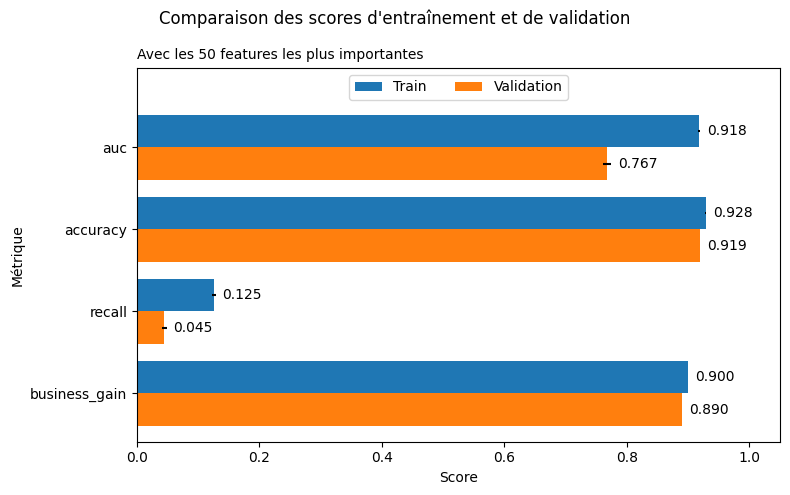

In [118]:
n_features = 50
features = list(importances.index)[:n_features]
X = sampled_train[features]
y = sampled_train["TARGET"]

clf = lgb.LGBMClassifier(
    n_threads=14,
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,  # Pour ne pas voir les logs
)
dic_train_scores, dic_val_scores = lgbm_cross_validate(model=clf, X=X, y=y)
mean_val_scores = {k: np.mean(v) for (k, v) in dic_val_scores.items()}
mean_train_scores = {k: np.mean(v) for (k, v) in dic_train_scores.items()}

fig = plot_evaluation_scores(
    train_scores=dic_train_scores,
    val_scores=dic_val_scores,
    title="Comparaison des scores d'entraînement et de validation",
    subtitle=f"Avec les {n_features} features les plus importantes",
    verbose=True,
)

plot_recall_mean(
    tn=mean_val_scores["tn"],
    fp=mean_val_scores["fp"],
    fn=mean_val_scores["fn"],
    tp=mean_val_scores["tp"],
)

In [ ]:
from cuml.model_selection import StratifiedKFold as CuStratifiedKFold

from sklearn.base import BaseEstimator, TransformerMixin, check_is_fitted
from cuml.linear_model import LinearRegression as CuLinearRegression
from cuml.metrics import r2_score

import time
from src.p7_preprocess import check_variances, cu_build_folds_list
from src.p7_util import format_time
from src.p7_constantes import EPSILON